In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
!nvidia-smi

Mon Jul  8 05:24:39 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0              29W /  70W |   8315MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [33]:
import os
path='/content/drive/MyDrive/reduced_dataset'

In [34]:
#removing corrupted images
from PIL import Image

def check_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()
            except (IOError, SyntaxError) as e:
                print(f"Bad file: {file_path}")
                os.remove(file_path)  # Remove the corrupted file

# Check and clean your dataset directory
dataset_path = '/content/drive/MyDrive/reduced_dataset'
check_images(dataset_path)


In [35]:
import tensorflow as tf
from tensorflow import keras

In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [37]:
train_data=ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

In [38]:
train_gen=train_data.flow_from_directory(
    path,
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32,
    subset='training',
    shuffle=True
)

Found 955 images belonging to 4 classes.


In [39]:
validation_gen=train_data.flow_from_directory(
    path,
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32,
    subset='validation',
    shuffle=True
)

Found 237 images belonging to 4 classes.


In [40]:
print(train_gen.class_indices)
print(validation_gen.class_indices)


{'East Indian Cuisine': 0, 'North Indian Cusine': 1, 'South Indian Cuisine': 2, 'West Indian Cuisine': 3}
{'East Indian Cuisine': 0, 'North Indian Cusine': 1, 'South Indian Cuisine': 2, 'West Indian Cuisine': 3}


In [41]:
from tensorflow.keras import layers,models
from tensorflow.keras.applications import VGG16

In [42]:
reference_model=VGG16(weights='imagenet',include_top=False, input_shape=(224, 224, 3))

In [43]:
# freezing the layers
for layer in reference_model.layers:
    layer.trainable=False

In [44]:
model=models.Sequential([
    reference_model,
    layers.Flatten(),
    layers.Dense(units=256,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(units=4,activation='softmax')
])

In [45]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy']

)

In [46]:
print(layer,layer.trainable)

<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7a6ccdf41e40> False


In [48]:
trained_model=model.fit(
    train_gen,
    epochs=10,
    validation_data=validation_gen,
    steps_per_epoch=len(train_gen),
    validation_steps=len(validation_gen)
)

Epoch 1/10
30/30 [==============================] - 56s 2s/step - loss: 16.1453 - accuracy: 0.4314 - val_loss: 1.2303 - val_accuracy: 0.5148
Epoch 2/10
30/30 [==============================] - 28s 961ms/step - loss: 1.2076 - accuracy: 0.5518 - val_loss: 1.1501 - val_accuracy: 0.5443
Epoch 3/10
30/30 [==============================] - 26s 878ms/step - loss: 1.1302 - accuracy: 0.5414 - val_loss: 1.0952 - val_accuracy: 0.5443
Epoch 4/10
30/30 [==============================] - 24s 807ms/step - loss: 1.0107 - accuracy: 0.5675 - val_loss: 1.0196 - val_accuracy: 0.5401
Epoch 5/10
30/30 [==============================] - 23s 770ms/step - loss: 0.9822 - accuracy: 0.5738 - val_loss: 1.0512 - val_accuracy: 0.5485
Epoch 6/10
30/30 [==============================] - 25s 823ms/step - loss: 0.9215 - accuracy: 0.5843 - val_loss: 1.0455 - val_accuracy: 0.5443
Epoch 7/10
30/30 [==============================] - 24s 798ms/step - loss: 0.9221 - accuracy: 0.5843 - val_loss: 1.1063 - val_accuracy: 0.5105
E

**Saving the Model as .h5 file**

In [49]:
saved_model=model.save('/content/drive/MyDrive/saved_model/classifier.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [50]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/saved_model/classifier.h5')

In [51]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 21138500 (80.64 MB)
Trainable params: 6423812 (24.50 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [52]:
y_predict=model.predict(validation_gen)

8/8 [==============================] - 6s 746ms/step


In [53]:
model.evaluate(validation_gen)

8/8 [==============================] - 5s 624ms/step - loss: 1.0501 - accuracy: 0.5781


[1.0501434803009033, 0.5780590772628784]

In [54]:
from sklearn.metrics import classification_report
y_true=validation_gen.classes
print(classification_report(y_true,y_predict.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.56      0.91      0.69       131
           2       0.00      0.00      0.00        18
           3       0.17      0.07      0.10        58

    accuracy                           0.52       237
   macro avg       0.18      0.24      0.20       237
weighted avg       0.35      0.52      0.41       237



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [55]:
#ploting epoch vs val_acc & epoch vs val_loss graph
import matplotlib.pyplot as plt
training_loss=trained_model.history['loss']
test_loss=trained_model.history['val_loss']
training_acc=trained_model.history['accuracy']
test_acc=trained_model.history['val_accuracy']
epochs=range(len(training_loss))

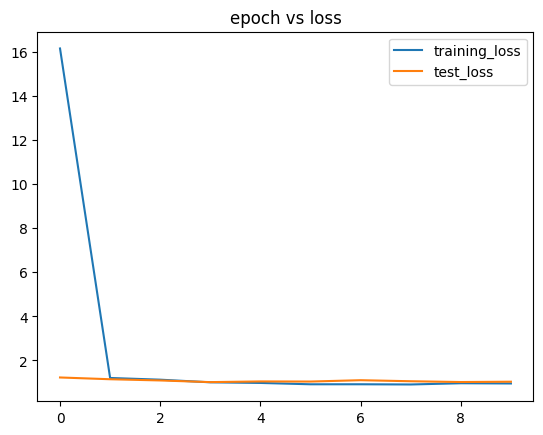

In [56]:

plt.title('epoch vs loss')
plt.plot(epochs,training_loss,label='training_loss')
plt.plot(epochs,test_loss,label='test_loss')
plt.legend()
plt.show()


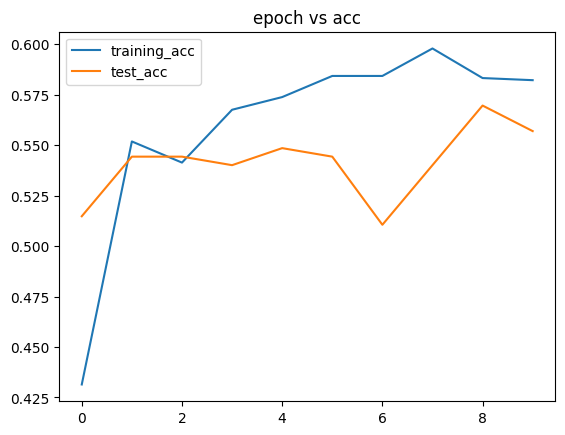

In [57]:

plt.title('epoch vs acc')
plt.plot(epochs,training_acc,label='training_acc')
plt.plot(epochs,test_acc,label='test_acc')
plt.legend()
plt.show()

Using the Saved model to predict new images as one of the classes

In [58]:
from keras.preprocessing import image
from keras.models import load_model
import numpy as np
#function to predict images
def predict_image(image_path,saved_model):
  img=image.load_img(image_path,target_size=(224,224))
  img=image.img_to_array(img)
  img=img/255.0

  img=np.expand_dims(img,axis=0)

  prediction=saved_model.predict(img)
  classes=['North_Indian','East_Indian','West_Indian','South_Indian']
  predicted_class=classes[np.argmax(prediction)]

  return predicted_class



In [59]:
saved_model=load_model('/content/drive/MyDrive/saved_model/classifier.h5')
image_path='/content/drive/MyDrive/new.jfif'
predicted_class=predict_image(image_path,saved_model)
print(predicted_class)

1/1 [==============================] - 0s 140ms/step
East_Indian
